In [1]:
import os
import cv2
import torch
import random
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from pathlib import Path
from mpl_toolkits.axes_grid1 import ImageGrid

import torch
import torch.backends.cudnn as cudnn
import torchvision.transforms.functional as TF
from gradcam.utils.image import show_cam_on_image
from gradcam.multimae_cam import MultiMAECAM
from gradcam.utils.model_targets import MultiMAESemanticSegmentationTarget

from multimae.models.multimae import pretrain_multimae_base
from multimae.utils.plot_utils import plot_predictions
from multimae.models.criterion import MaskedCrossEntropyLoss, MaskedMSELoss, MaskedL1Loss

from functools import partial
from detectron2.data import MetadataCatalog
from multimae.models.input_adapters import PatchedInputAdapter, SemSegInputAdapter
from multimae.models.output_adapters import SpatialOutputAdapter
from pipelines.utils.data_utils import get_semseg_metadata
from pipelines.utils.data_utils import preprocess_multimae_inputs_in_batch

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
flightmare_path = Path(os.environ["FLIGHTMARE_PATH"])
device = torch.device('cuda')
prefix = "step_000358_"

In [3]:
multimae_path = flightmare_path.parent / "vision_backbones/MultiMAE"
sample_rgb = multimae_path / f"samples/{prefix}rgb.png"
sample_depth = multimae_path / f"samples/{prefix}depth.npy"
sample_semseg = multimae_path / f"samples/{prefix}semseg.png"
sample_label = multimae_path / f"samples/{prefix}label.npz"

In [4]:
# configure for detectron dataset (for prediection)
eval_data_path = multimae_path / "datasets/test/val"
metadata = get_semseg_metadata(eval_data_path)

(224, 224, 3)


(-0.5, 639.5, 479.5, -0.5)

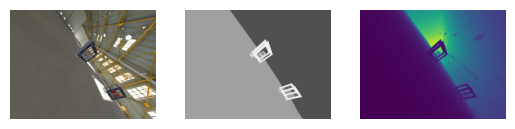

In [5]:
image = cv2.imread(str(sample_rgb))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_float = torch.from_numpy(image).float().permute(2, 0, 1) / 255.0
c, h, w = image_float.shape

image_float = TF.center_crop(image_float, min([h, w]))
image_float = TF.resize(image_float, 224)
image_float = image_float.permute(1, 2, 0).numpy().astype(np.float32)
print(image_float.shape)

image = Image.fromarray(image)

semseg = cv2.imread(str(sample_semseg))
depth = np.load(str(sample_depth))

fig, axs = plt.subplots(1, 3)
axs[0].imshow(image)
axs[0].axis('off')

axs[1].imshow(semseg * 80)
axs[1].axis('off')

axs[2].imshow(depth)
axs[2].axis('off')

In [6]:
DOMAINS = ['rgb', 'depth']

DOMAIN_CONF = {
    'rgb': {
        'input_adapter': partial(PatchedInputAdapter, num_channels=3, stride_level=1),
        'output_adapter': partial(SpatialOutputAdapter, num_channels=3, stride_level=1),
    },
    'depth': {
        'input_adapter': partial(PatchedInputAdapter, num_channels=1, stride_level=1),
        'output_adapter': partial(SpatialOutputAdapter, num_channels=1, stride_level=1),
    },
    'semseg': {
        'input_adapter': partial(SemSegInputAdapter, num_classes=133,
                                 dim_class_emb=64, interpolate_class_emb=False, stride_level=4),
        'output_adapter': partial(SpatialOutputAdapter, num_channels=133, stride_level=4),
    },
}

input_adapters = {
    domain: dinfo['input_adapter'](patch_size_full=16)
    for domain, dinfo in DOMAIN_CONF.items() if domain in DOMAINS
}

output_adapters = {
    domain: dinfo['output_adapter'](
        patch_size_full=16,
        dim_tokens=256,
        use_task_queries=True,
        depth=2,
        context_tasks=DOMAINS,
        task=domain
    )
    for domain, dinfo in DOMAIN_CONF.items()
}

model = pretrain_multimae_base(input_adapters=input_adapters, output_adapters=output_adapters)

In [7]:
model_name = "pretrained"

models = {
    "unmask-semseg-loss": "03-11-17-16-39",
    "gate-half-depth-semseg": "03-11-23-14-17",
    "no-standard-depth": "03-12-11-46-23",
    "only-gate-mask-rgb_unmask-depth-loss": "03-12-18-08-15",
    "depth-semseg": "03-12-23-04-05",
    "fine-semseg": "03-13-11-59-42"
}

In [8]:
if model_name == "pretrained":
    CKPT_URL = 'https://github.com/EPFL-VILAB/MultiMAE/releases/download/pretrained-weights/multimae-b_98_rgb+-depth-semseg_1600e_multivit-afff3f8c.pth'
    ckpt = torch.hub.load_state_dict_from_url(CKPT_URL, map_location='cpu')
    model.load_state_dict(ckpt['model'], strict=False)
else:
    pretrained_model_path = multimae_path / f"results/pretrain/{models[model_name]}/checkpoint-299.pth"
    ckpt = torch.load(pretrained_model_path, map_location='cpu')
    model.load_state_dict(ckpt['model'], strict=True)   

### load checkpoints

In [9]:
model.to("cuda")
model.eval()

MultiMAE(
  (input_adapters): ModuleDict(
    (rgb): PatchedInputAdapter(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (depth): PatchedInputAdapter(
      (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(16, 16))
    )
  )
  (output_adapters): ModuleDict(
    (rgb): SpatialOutputAdapter(
      (task_embeddings): ParameterDict(
          (depth): Parameter containing: [torch.cuda.FloatTensor of size 1x1x256 (GPU 0)]
          (rgb): Parameter containing: [torch.cuda.FloatTensor of size 1x1x256 (GPU 0)]
      )
      (decoder): CrossAttention(
        (q): Linear(in_features=256, out_features=256, bias=True)
        (kv): Linear(in_features=256, out_features=512, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=256, out_features=256, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (context_norm): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
      (query_norm): LayerNo

In [10]:
# Pre-process RGB, depth and semseg to the MultiMAE input format
input_dict = {
    "rgb": np.expand_dims(image, [0, -1]),
    "depth": np.expand_dims(depth, [0, -1]),
    "semseg": np.expand_dims(semseg[:, :, 0], [0, 3, 4])
}

print(input_dict["rgb"].shape)
print(input_dict["depth"].shape)
print(input_dict["semseg"].shape)

processed_inputs = preprocess_multimae_inputs_in_batch(input_dict, batch_axis=True)
    
# To GPU
processed_inputs = {k: v.squeeze(-1).to("cuda") for k,v in processed_inputs.items()}

print(processed_inputs["rgb"].shape)
print(processed_inputs["depth"].shape)
print(processed_inputs["semseg"].shape)

inputs = {k: processed_inputs[k] for k in DOMAINS}

(1, 480, 640, 3, 1)
(1, 480, 640, 1, 1)
(1, 480, 640, 1, 1)
torch.Size([1, 3, 224, 224])
torch.Size([1, 1, 224, 224])
torch.Size([1, 56, 56])


In [11]:
seed = 7
torch.manual_seed(seed) # change seed to resample new mask
np.random.seed(seed)
random.seed(seed)
cudnn.benchmark = True

In [12]:
a = torch.rand(10, 196)
b = torch.zeros(10, 196)
b[a < 0.5] = 1
print(torch.sum(b, dim=1))
b_idx = torch.argsort(b, dim=1)
b_keep = b_idx[:, :16]
print(b_keep)
c = torch.ones(10, 196)
c.scatter_(1, b_keep, 0)
print(torch.sum(c, dim=1))
print(c[0, :])

tensor([ 98., 105.,  96.,  98.,  92., 106.,  90., 104.,  91.,  93.])
tensor([[161, 153, 154,  89,  88,  87,  86, 157, 158,  80,  78,  77,  76,  75,
          92,  72],
        [161, 151,  85,  84,  83,  82, 153,  77, 157,  73,  70,  69,  68, 150,
          65, 163],
        [ 67, 112,  78,  77,  76,  75, 161, 113, 163,  71,  70,  69, 114, 142,
         165,  65],
        [112, 103, 104, 105, 106, 107, 108, 110, 111, 102, 117, 118, 122, 123,
         126, 128],
        [158, 150,  92, 152,  88,  87,  86,  84, 156,  81,  80,  79,  78,  77,
         157, 149],
        [106, 136, 135, 134, 132, 130, 129, 127, 121, 120, 119, 118, 113, 111,
         110, 108],
        [117,  99, 100, 102, 107, 108, 109, 110, 114,   0, 120, 121, 122, 124,
         125, 129],
        [ 65,  77, 153, 154, 155,  73,  72, 156,  70,  69, 157, 158,  66,  78,
         110,  61],
        [168, 159, 160,  80, 145, 116,  77,  76,  75, 163, 164, 144, 118, 167,
         158, 169],
        [115, 103, 104, 105, 106, 107, 1

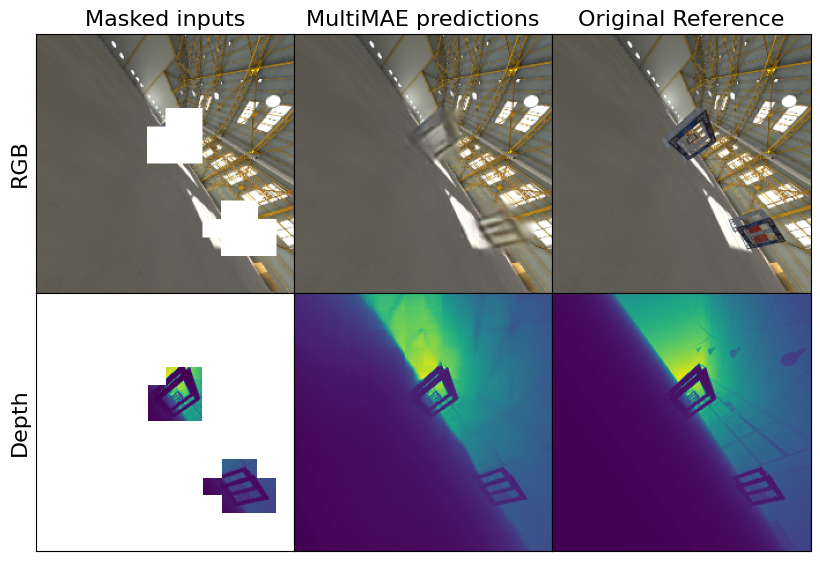

In [13]:
preds, masks = model(
    processed_inputs, 
    num_encoded_tokens=196,
    alphas=1.0,
    mask_type="gate-oriented",
    semseg_gt=processed_inputs["semseg"],
    masked_rgb_gate_only=True,
    in_domains=DOMAINS
)

preds = {domain: pred.detach().cpu() for domain, pred in preds.items()}
masks = {domain: mask.detach().cpu() for domain, mask in masks.items()}

res = plot_predictions(inputs, preds, masks, metadata=metadata)

In [14]:
def plot_vis(res, image_float, grayscale_cam):
    fig = plt.figure(figsize=(10, 10))
    axs = ImageGrid(fig, 111, nrows_ncols=(2, 3), axes_pad=0)

    axs[0].imshow(res["rgb_input"])
    axs[0].axis('off')
    axs[0].set_title("RGB")

    axs[1].imshow(res["depth_input"])
    axs[1].axis('off')
    axs[1].set_title("Depth")

    axs[2].imshow(res["semseg_input"])
    axs[2].axis('off')
    axs[2].set_title("Semseg")

    cam_rgb = show_cam_on_image(image_float, grayscale_cam[0, :, :], use_rgb=True)
    axs[3].imshow(cam_rgb)
    axs[3].axis('off')

    axs[4].imshow(cam_rgb)
    axs[4].axis('off')

    axs[5].imshow(cam_rgb)
    axs[5].axis('off')

In [15]:
target_layers = [model.encoder[-1].norm1]
cam = MultiMAECAM(model=model, target_layers=target_layers, use_cuda=True)

metadata = MetadataCatalog.get("coco_2017_val_panoptic")
for i, class_name in enumerate(metadata.thing_classes):
    print(i, class_name)

gate_class_id = 118
gate_mask_semseg_gt = torch.zeros_like(processed_inputs["semseg"])
gate_mask_semseg_gt[processed_inputs["semseg"] == 1] = 1

0 person
1 bicycle
2 car
3 motorcycle
4 airplane
5 bus
6 train
7 truck
8 boat
9 traffic light
10 fire hydrant
11 stop sign
12 parking meter
13 bench
14 bird
15 cat
16 dog
17 horse
18 sheep
19 cow
20 elephant
21 bear
22 zebra
23 giraffe
24 backpack
25 umbrella
26 handbag
27 tie
28 suitcase
29 frisbee
30 skis
31 snowboard
32 sports ball
33 kite
34 baseball bat
35 baseball glove
36 skateboard
37 surfboard
38 tennis racket
39 bottle
40 wine glass
41 cup
42 fork
43 knife
44 spoon
45 bowl
46 banana
47 apple
48 sandwich
49 orange
50 broccoli
51 carrot
52 hot dog
53 pizza
54 donut
55 cake
56 chair
57 couch
58 potted plant
59 bed
60 dining table
61 toilet
62 tv
63 laptop
64 mouse
65 remote
66 keyboard
67 cell phone
68 microwave
69 oven
70 toaster
71 sink
72 refrigerator
73 book
74 clock
75 vase
76 scissors
77 teddy bear
78 hair drier
79 toothbrush
80 banner
81 blanket
82 bridge
83 cardboard
84 counter
85 curtain
86 door-stuff
87 floor-wood
88 flower
89 fruit
90 gravel
91 house
92 light
93 mirro

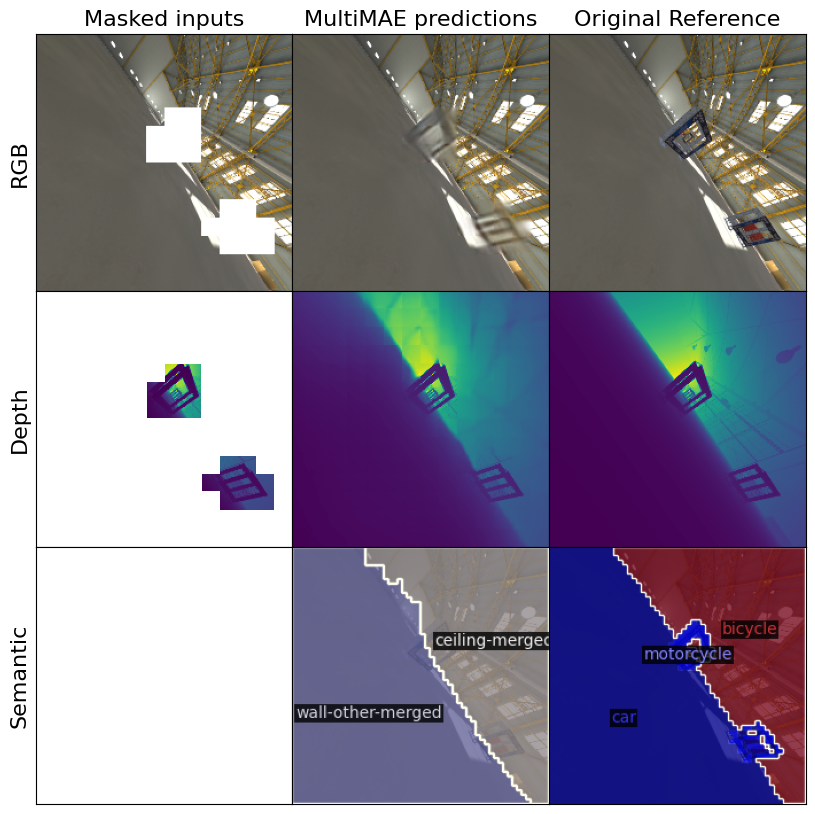

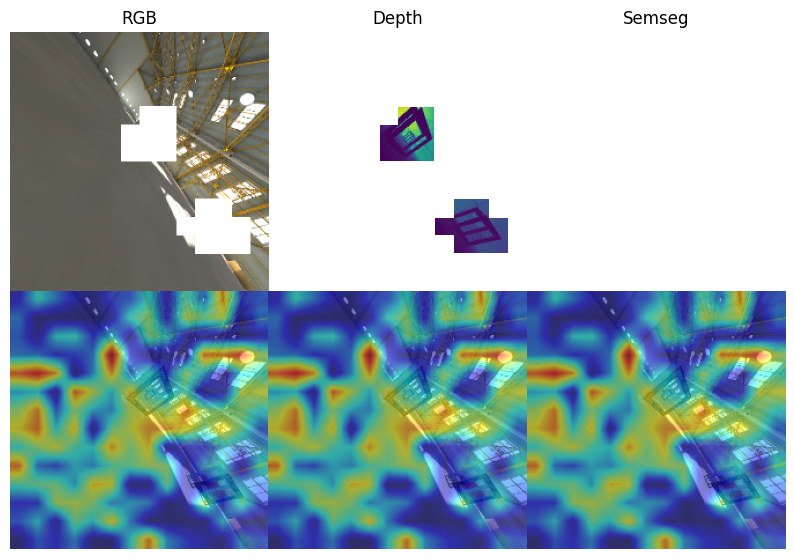

In [16]:
targets = {
    "rgb": MaskedMSELoss(),
    "depth": MaskedL1Loss(),
    "semseg": MultiMAESemanticSegmentationTarget(gate_class_id, gate_mask_semseg_gt)
}

preds, task_masks, all_grayscale_cam = cam(
    input_tensor=processed_inputs, 
    targets=targets, 
    num_encoded_tokens=196, 
    mask_type="gate-oriented", 
    semseg_gt=processed_inputs["semseg"],
    masked_rgb_gate_only=True,
    in_domains=DOMAINS)

preds = {domain: pred.detach().cpu() for domain, pred in preds.items()}
masks = {domain: mask.detach().cpu() for domain, mask in task_masks.items()}

all_res = plot_predictions(processed_inputs, preds, masks, show_img=True)
plot_vis(all_res, image_float, all_grayscale_cam)

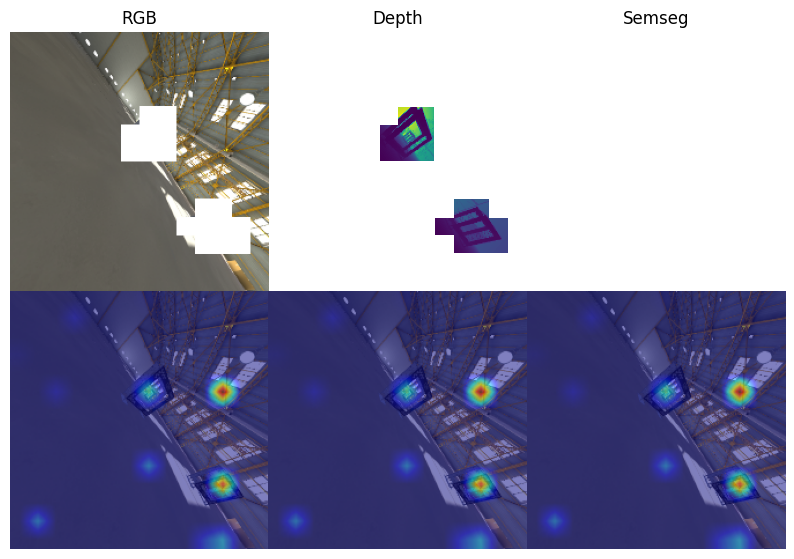

In [17]:
targets = {
    "rgb": MaskedMSELoss()
}
preds, task_masks, rgb_grayscale_cam = cam(
    input_tensor=inputs, 
    targets=targets, 
    # inputs for multimae preditions
    num_encoded_tokens=196, 
    mask_inputs=True,
    task_masks=task_masks)

preds = {domain: pred.detach().cpu() for domain, pred in preds.items()}
masks = {domain: mask.detach().cpu() for domain, mask in task_masks.items()}

rgb_res = plot_predictions(processed_inputs, preds, masks, show_img=False)
plot_vis(rgb_res, image_float, rgb_grayscale_cam)

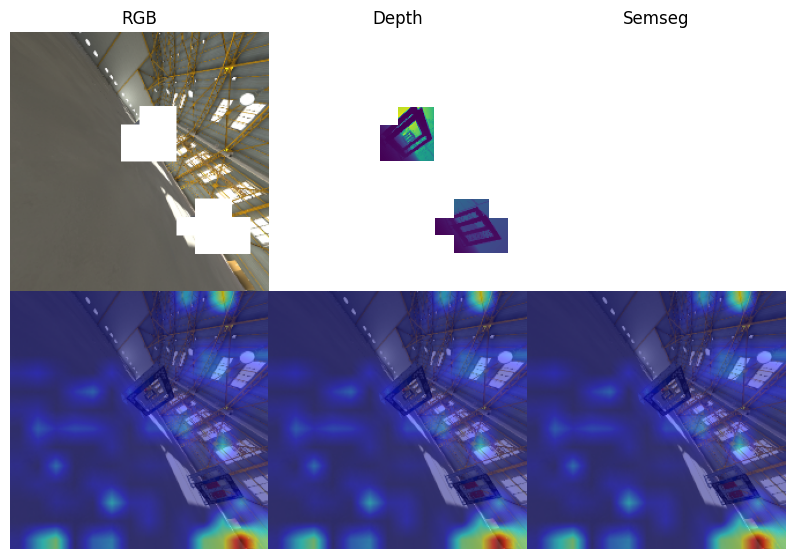

In [18]:
targets = {
    "depth": MaskedL1Loss(),
}
preds, task_masks, depth_grayscale_cam = cam(
    input_tensor=inputs, 
    targets=targets, 
    # inputs for multimae preditions
    num_encoded_tokens=196, 
    mask_inputs=True,
    task_masks=task_masks)

preds = {domain: pred.detach().cpu() for domain, pred in preds.items()}
masks = {domain: mask.detach().cpu() for domain, mask in task_masks.items()}

depth_res = plot_predictions(processed_inputs, preds, masks, show_img=False)
plot_vis(depth_res, image_float, depth_grayscale_cam)

tensor([118, 131])


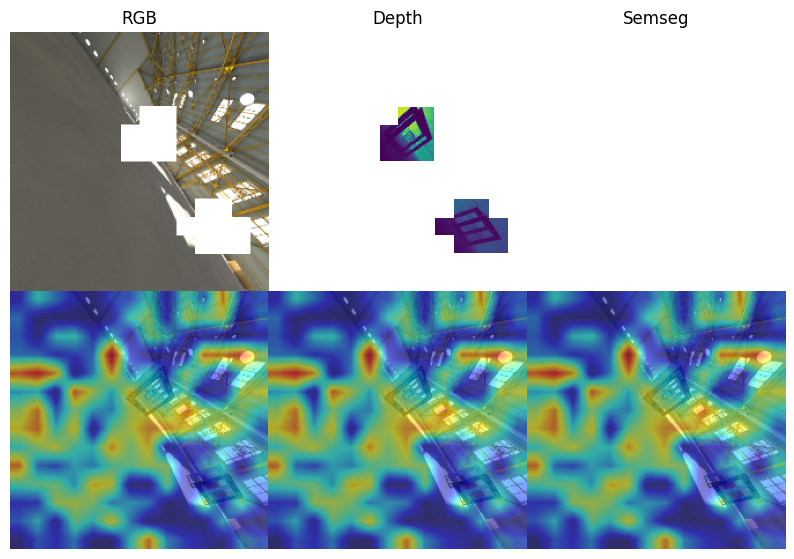

In [19]:
targets = {
    "semseg": MultiMAESemanticSegmentationTarget(gate_class_id, gate_mask_semseg_gt)
}
preds, task_masks, semseg_grayscale_cam = cam(
    input_tensor=processed_inputs, 
    targets=targets, 
    # inputs for multimae preditions
    num_encoded_tokens=196, 
    mask_inputs=True,
    task_masks=task_masks)

preds = {domain: pred.detach().cpu() for domain, pred in preds.items()}
masks = {domain: mask.detach().cpu() for domain, mask in task_masks.items()}

print(preds["semseg"].argmax(1).unique())

semseg_res = plot_predictions(processed_inputs, preds, masks, show_img=False)
plot_vis(semseg_res, image_float, semseg_grayscale_cam)

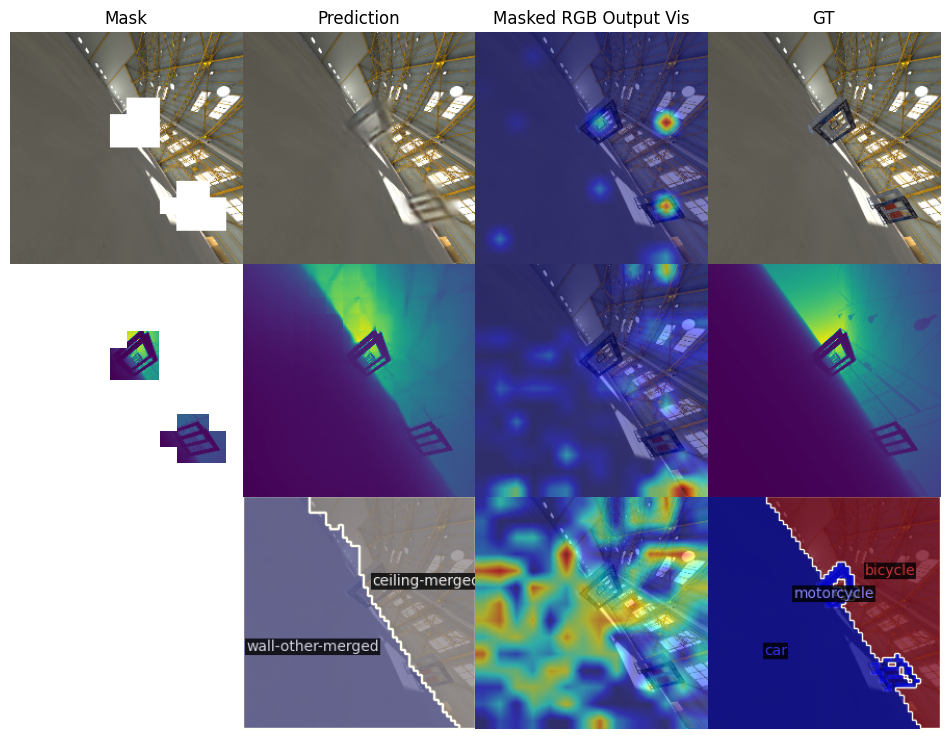

In [20]:
fig = plt.figure(figsize=(12, 12))
axs = ImageGrid(fig, 111, nrows_ncols=(3, 4), axes_pad=0)

axs[0].imshow(all_res["rgb_input"])
axs[0].axis('off')
axs[0].set_title("Mask")
axs[0].set_ylabel("RGB")

axs[1].imshow(all_res["rgb_pred"])
axs[1].axis('off')
axs[1].set_title("Prediction")

cam_rgb = show_cam_on_image(image_float, rgb_grayscale_cam[0, :, :], use_rgb=True)
axs[2].imshow(cam_rgb)
axs[2].axis('off')
axs[2].set_title("Masked RGB Output Vis")

axs[3].imshow(all_res["rgb_gt"])
axs[3].axis('off')
axs[3].set_title("GT")

axs[4].imshow(all_res["depth_input"])
axs[4].axis('off')
axs[4].set_ylabel("Depth")

axs[5].imshow(all_res["depth_pred"])
axs[5].axis('off')

cam_depth = show_cam_on_image(image_float, depth_grayscale_cam[0, :, :], use_rgb=True)
axs[6].imshow(cam_depth)
axs[6].axis('off')

axs[7].imshow(all_res["depth_gt"])
axs[7].axis('off')

axs[8].imshow(all_res["semseg_input"])
axs[8].axis('off')
axs[8].set_ylabel("Semseg")

axs[9].imshow(all_res["semseg_pred"])
axs[9].axis('off')

cam_semseg = show_cam_on_image(image_float, semseg_grayscale_cam[0, :, :], use_rgb=True)
axs[10].imshow(cam_semseg)
axs[10].axis('off')

axs[11].imshow(all_res["semseg_gt"])
axs[11].axis('off')

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])